In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import load_model, save_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
# check if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11568588604517972551
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9585045064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8892060255824261638
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
json_file = open('models\modelP.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


In [18]:
loaded_model.load_weights("models\modelW_last.h5")

In [5]:
def one_hot_to_seg(img_lst_one_hot):
    img_lst_new = []
    for one_hot_img in range(len(img_lst_one_hot)):
        img_new = np.copy(img_lst_one_hot[one_hot_img])
        for lbl in range(0,5):
            img_new[:,:,lbl]*=lbl*255/5
        img_lst_new.append(np.sum(img_new,axis=2))
    return img_lst_new

In [19]:
X_test_test = []
Y_test_test = []
n_classes = 5

img = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)

#         print('E:\YKL\Thorlabs VSCAN Labeling\scan30\{}'.format(img_fl))
resized_img = cv2.equalizeHist(np.clip(cv2.resize(img,(400, 352), interpolation = cv2.INTER_NEAREST),0,255))
resized_denoised_img = cv2.fastNlMeansDenoising(resized_img,10,7,21)

X_test_test.append(resized_denoised_img)

msk = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)
resized_msk = np.clip(cv2.resize(msk,(400, 352), interpolation = cv2.INTER_NEAREST),0,4)

# additional post processing for one hot encoding mask
resized_msk[resized_msk==0] = 6;
resized_msk_one_hot = np.zeros((resized_msk.shape[0], resized_msk.shape[1], n_classes))
for i, unique_value in enumerate(np.unique(resized_msk)):
    resized_msk_one_hot[:, :, i][resized_msk == unique_value] = 1

Y_test_test.append(resized_msk_one_hot)

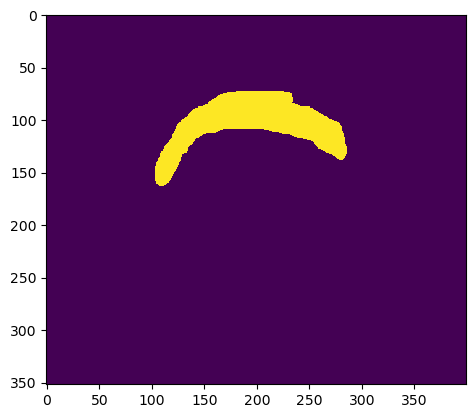

In [20]:
plt.imshow(Y_test_test[0][:,:,0])

In [21]:
X_test_test = np.array(X_test_test)
X_test_test = X_test_test[:, :, :, np.newaxis]
X_test_test = X_test_test / 255

In [27]:
yp_test = loaded_model.predict(x=X_test_test, batch_size=1, verbose=1)
#yp_test = np.round(yp_test,0)    
yp_test_disp = one_hot_to_seg(yp_test)

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'Prediction')

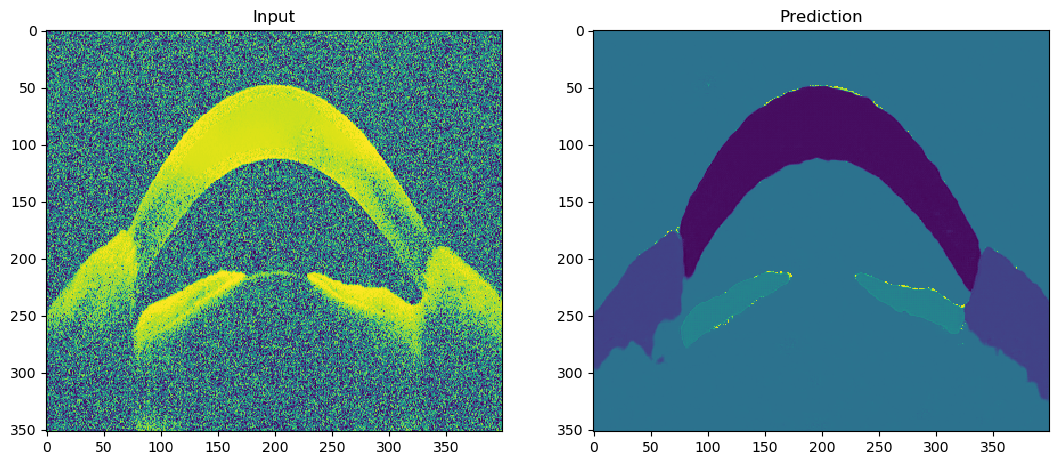

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test_test[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow(yp_test_disp[0].reshape(352,400))
plt.title('Prediction')